# Découverte des signaux audio

## Un peu de théorie

Un signal audio est l'enregistrement de la fluctuation de pression de l'air (en Pascal) autour d'une pression d'équilibre. Un bruit ou un son peut ainsi être représenté sous la forme d'une *onde*, qui se propage dans l'espace au cours du temps.

Les ondes acoustiques ont donc besoin de 3 éléments pour pouvoir être générées puis perçues :
- un émetteur : dans un nombre important de cas il s'agit d'un élément mécanique qui vibre (vos cordes vocales)
- un milieu de propagation : sans air ou eau, pas de son (Star Wars est un fake total)
- un récepteur : une membrane qui va vibrer lorsqu'elle va être frappée par l'onde qui lui arrive dessus (votre tympan)

Cette explication très rapide et imagée de l'acoustique n'a pas pour vocation d'être exacte, elle vous permet seulement de comprendre un peu mieux les signaux que vous aller utiliser, et surtout d'où ils viennent.

D'un point de vue du traitement du signal, tout le système de génération du signal que l'on reçoit n'est pas très important. Ce qui compte c'est que c'est une grandeur scalaire qui est enregistrée au cours du temps (en Pascal) par un microphone.

On se retrouve donc avec une courbe au cours du temps, qui varie en fonction de l'intensité du son qui a été reçu.

Cependant une notion très importante du traitement du signal à comprendre concerne le fait que ce signal, bien que continu dans la vie réelle, est *numérisé*, et donc discrétisé dès qu'il est passé sur notre ordinateur. On se retrouve donc non plus avec un signal continu (dit *analogique*), mais avecun signal discret (dit *numérique*), et la bonne description de ce signal dépend de la fréquence à laquelle on enregistre deux points consécutifs du signal ce qui définit notre **fréquence d'échantilonnage**. Plus la fréquence d'échantillonnage est importante, mieux le signal est décrit, mais plus il prend de place en mémoire.

A travers ce Notebook, vous allez découvrir les bases du traitement de signaux audio, et notamment comment on peut les créer et les écouter, mais aussi quels sont les deux principaux sons que l'on aime souvent manipuler en traitement du signal : le *sinus* et le *bruit blanc*. 
Il a pour vocation de vous faire comprendre comment on manipule ces signaux, et vous permettra de tester une première classification entre ces deux types de signaux facile à différencier.

## En pratique !

In [1]:
# Import des packages nécessaires
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import svm
import pickle
from joblib import dump
from features_functions import compute_features
import os
import random
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
# Paramètres d'un signal audio
duree = 2 # Durée en secondes
fe = 44100 # Fréquence d'échatillonnage en Hertz, 44100 est très courant en audio
amp = 0.1 # Amplitude en Pascal

In [3]:
# Création d'un sinus
f0 = 1000 # Fréquence du sinus
t = np.arange(0, duree, 1/fe) # Création du vecteur temporel (1 point pour chaque échantillon)
sinus = amp*np.sin(2*np.pi*f0*t)

Text(0, 0.5, 'Amplitude (Pa)')

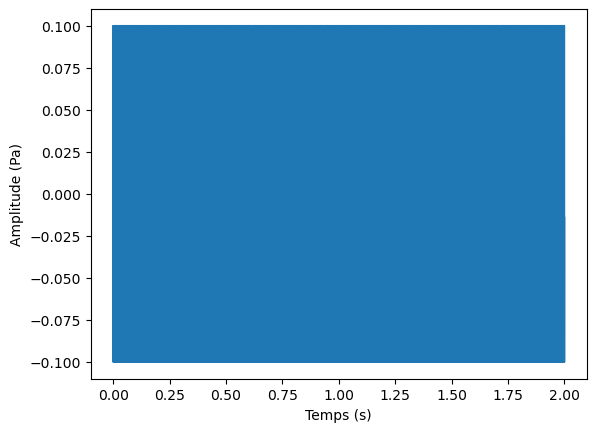

In [4]:
# Représentation du sinus
plt.figure()
plt.plot(t, sinus)
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude (Pa)")

On représente un sinus au cours du temps, avec le temps choisi comme durée du signal et l'amplitude voulue.
Que se passe-t-il si on l'écoute ?

In [5]:
# Puis on l'écoute
sd.play(sinus, fe)

# On peut éventuellement le sauvegarder sur disque
fichier_sinus = open('sinus', 'wb')
pickle.dump(sinus, fichier_sinus)

fichier_sinus.close()

#### Exercices

Essayez de jouer avec les paramètres du signal pour voir à partir de quel moment il y a des choses qui ne se passent pas bien !

In [6]:
# On crée ensuite un autre type de son : le bruit blanc
bb = amp*np.random.randn(duree*fe)

Text(0, 0.5, 'Amplitude (Pa)')

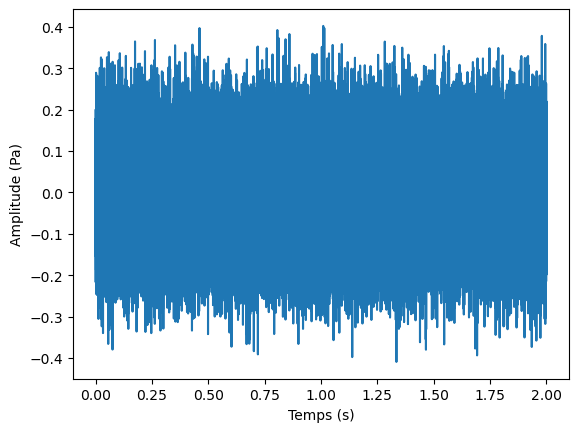

In [7]:
# On le trace pour voir à quoi il ressemble
plt.figure()
plt.plot(t, bb)
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude (Pa)")

A votre avis, qu'est ce que ce son peut représenter ?
Pour en avoir une idée nous allons l'écouter.

In [8]:
# Ecoute du bruit blanc
sd.play(bb, fe)

# Export sur disque
fichier_bb = open('bb', 'wb')
pickle.dump(bb, fichier_bb)

fichier_bb.close()

#### Exercices

Expliquez la différence entre un bruit blanc et un sinus selon vous.
Regénérez des bruits blancs à partir du même code, sont-ils strictement les mêmes ? 
Si non, comment faire pour s'assurer qu'ils le soient ?

*Un sinus a une amplitude constante, tandis qu'un bruit blanc a une amplitude qui varie en fonction du temps*

## Générez votre base de données

A partir des deux sons que vous avez générés, vous allez devoir créer une base de données qui permet de différencier entre les sinus et les bruits blancs. Sur quoi pouvez-vous jouer pour construire une base de données qui permet de différencier ces deux sons ?

Une fois que vous avez votre idée, construisez votre base de données !

In [9]:
# Paramètres d'un signal audio
duree = 2 # Durée en secondes
fe = 44100 # Fréquence d'échatillonnage en Hertz, 44100 est très courant en audio
amp = 0.1 # Amplitude en Pascal

In [10]:
amp = 0.1
number=1
for i in range(10) :
    amp = amp+0.1
    for j in range(10) :
        number = number+1
        f0 =  random.randint(20,20000)
        t = np.arange(0, duree, 1/fe)
        sinus = amp*np.sin(2*np.pi*f0*t)
        bb = amp*np.random.randn(duree*fe)
        name_bb = "bb" + str(number)
        name_sinus = "sin" + str(number)
        fichier_bb = open(name_bb, 'wb')
        pickle.dump(bb, fichier_bb)
        fichier_bb.close()
        fichier_sinus = open(name_sinus, 'wb')
        pickle.dump(sinus, fichier_sinus)
        fichier_sinus.close()

In [11]:
signals = os.listdir('C:\\Users\\Simplon\\Downloads\\brief-audio-main\\brief-audio-main\\notebook_audio\\Data')
Labels = []
Features = []
features_list = []

# LOOP OVER THE SIGNALS
for index, i in enumerate(signals):
    # Get an input signal
    with open(f"data/{i}", 'rb') as f:
        input_sig = pickle.load(f)

    # Compute the signal in three domains
    sig_sq = input_sig**2
    sig_t = input_sig / np.sqrt(sig_sq.sum())
    sig_f = np.absolute(np.fft.fft(sig_t))
    sig_c = np.absolute(np.fft.fft(sig_f))

    # Compute the features and store them

    N_feat, features_list = compute_features(sig_t, sig_f[:sig_t.shape[0]//2], sig_c[:sig_t.shape[0]//2])
    features_vector = np.array(features_list)[np.newaxis,:]

    # Store the obtained features in a np.arrays
     #2D np.array with features_vector in it, for each signal
    Features.append(features_vector)

    
    # Store the labels
    # np.array with labels in it, for each signal
    if 'sin' in i:
        Labels.append('sinus')
    else:
        Labels.append('white')
        
learningFeatures= np.asarray(Features)
learningFeatures= np.reshape(learningFeatures,(200,71))
learningLabels= np.asarray(Labels)

In [20]:
N_feat

71

In [13]:
# Encode the class names
labelEncoder = preprocessing.LabelEncoder().fit(learningLabels)
learningLabelsStd = labelEncoder.transform(learningLabels)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(learningFeatures, learningLabelsStd, test_size=0.8, random_state=0

SyntaxError: unexpected EOF while parsing (892767515.py, line 1)

In [ ]:
learningFeatures.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(learningFeatures, learningLabelsStd, test_size=0.8, random_state=0)

model = svm.SVC(C=10, kernel='linear')
scaler = preprocessing.StandardScaler(with_mean=True).fit(X_train)
X_scaled = scaler.transform(X_train)
model.fit(X_scaled, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.model_selection import learning_curve,cross_val_score

In [ ]:
def plot_learning_curve (nom_model, jeu_entrainement, target_entrainement) :
    # Génération de la courbe d'apprentissage
    train_sizes, train_scores, test_scores = learning_curve(nom_model, jeu_entrainement, target_entrainement, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

    # Calcul des scores moyens et des écarts types pour les ensembles d'entraînement et de test
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Tracé de la courbe d'apprentissage avec redimensionnement de la figure
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("Courbe d'apprentissage")
    ax.set_xlabel("Taille de l'ensemble d'entraînement")
    ax.set_ylabel("Score")
    ax.grid()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validation croisée")
    ax.legend(loc="best")
    plt.show()

In [ ]:
plot_learning_curve(model,X_train,y_train)